In [3]:
%load_ext autoreload
%autoreload 2 

* 이미지를 VAE로 Embedding하여 얻은 vector의 similarity와 풍속데이터의 Similarity 비교
* 체크해야 할 것
    - 풍속기록이 있는 데이터만 필요하며, 일부는 Train 일부는 test 이를 구분해야 할 필요가 있음

In [4]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

import yaml
import torch
from torchvision import transforms, datasets
from torch.utils.data import SubsetRandomSampler, DataLoader, TensorDataset

from src.hillshpaeDataModule import MySimCLRTrainDataTransform
from simCLR import *
from src import *

In [5]:
# Wind data load

with open('../../Share_Data/windspeed/_Main_dataset.pickle', 'rb') as f:
    windspeed_dataset = pickle.load(f)

station_list = list(windspeed_dataset.keys())
windspeed_list = []
for item in windspeed_dataset.values():
    windspeed_list.append(item[3])
windspeed_list = np.array(windspeed_list)

with open('../../Share_Data/windspeed/WAS_journal_reverseVcwindspeed.pickle', 'rb') as f:
    windspeed_list = np.array(pickle.load(f))

In [6]:
# load config
config_path = 'configs/simclr_rgb.yaml'
checkpoint_path = '../../Share_Data/logs/SimCLR_CART/last.ckpt'

with open(config_path, 'rb') as f:
    config = yaml.safe_load(f)

#load vae model
untrained_model = simclr_model[config['model_params']['name']](**config['model_params'], num_samples=10)
model = simclr_model[config['model_params']['name']](**config['model_params'], num_samples=10)

#checkpoint load
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu')) # when using CPU
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [7]:
# load img data
IMG_PATH = '../../Share_Data/satellite/jpg_cart_d10/_jpg_cart_d10/{}.jpg'

img_list =[ ]
label_list = []
for station_code in station_list:
    img = Image.open(IMG_PATH.format(station_code)).resize([config['exp_parmas']['img_size']]*2)
    img_list.append(np.array(img))
    label_list.append(station_code)

img_list = (np.array(img_list)/255.)*2-1
tensor_img = torch.Tensor(img_list).permute(0,3,1,2)
tensor_dataset = TensorDataset(tensor_img)
dataloader = DataLoader(tensor_dataset)

In [8]:
model_latent = model.forward(tensor_img)
untrained_latent = untrained_model.forward(tensor_img)

model_projection = model.Projection(model_latent)
untrained_model_projection = untrained_model.Projection(untrained_latent)

print('size of latent : {}'.format(model_latent.size()))
print('size of projection : {}'.format(model_projection.size()))

size of latent : torch.Size([349, 512, 4, 4])
size of projection : torch.Size([349, 32])


# Analysis

In [18]:
#windspeed difference matrix

windspeed_diff_list = []
for i in windspeed_list:
    temp_list = []
    for j in windspeed_list:
        temp_list.append(abs(i-j))
    windspeed_diff_list.append(temp_list)
windspeed_diff_list = np.array(windspeed_diff_list)

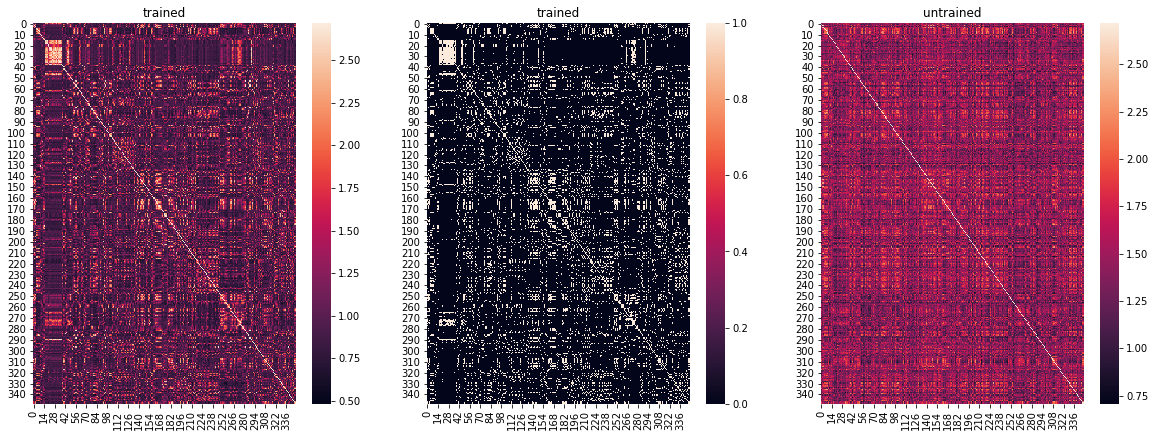

In [19]:
model_n = model_projection.norm(dim=1)[:,None]
model_n = torch.max(model_n, 1e-8*torch.ones_like(model_n))

un_model_n = untrained_model_projection.norm(dim=1)[:, None]
un_model_n = torch.max(un_model_n, 1e-8*torch.ones_like(un_model_n))

cov = torch.mm(model_projection/model_n, (model_projection/model_n).t().contiguous())
sim = torch.exp(cov)
untrained_cov = torch.mm(untrained_model_projection/un_model_n, (untrained_model_projection/un_model_n).t().contiguous())
untrained_sim = torch.exp(untrained_cov)

windspeed_diff = np.exp(-windspeed_diff_list/windspeed_diff_list.max()+1)

plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
plt.title('trained')
sns.heatmap(sim.detach().numpy())

plt.subplot(1,3,2)
plt.title('trained')
sns.heatmap(sim.detach().numpy()>1.5)

plt.subplot(1,3,3)
plt.title('untrained')
sns.heatmap(untrained_sim.detach().numpy())

#plt.subplot(1,3,3)
#plt.title('windspeed')
#sns.heatmap(windspeed_diff)
plt.show()

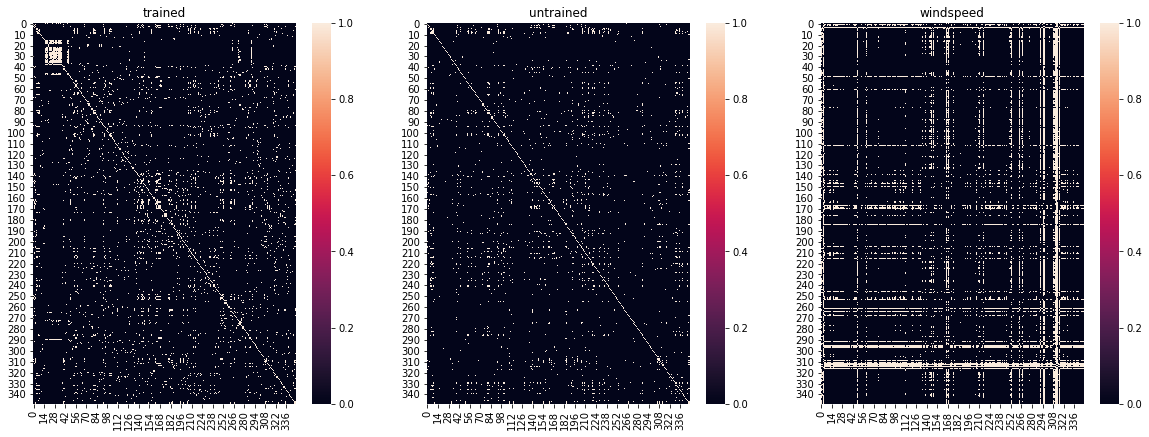

In [20]:

plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
plt.title('trained')
sns.heatmap(sim.detach().numpy()>2)

plt.subplot(1,3,2)
plt.title('untrained')
sns.heatmap(untrained_sim.detach().numpy()>2)

plt.subplot(1,3,3)
plt.title('windspeed')
sns.heatmap(windspeed_diff<2)
plt.show()

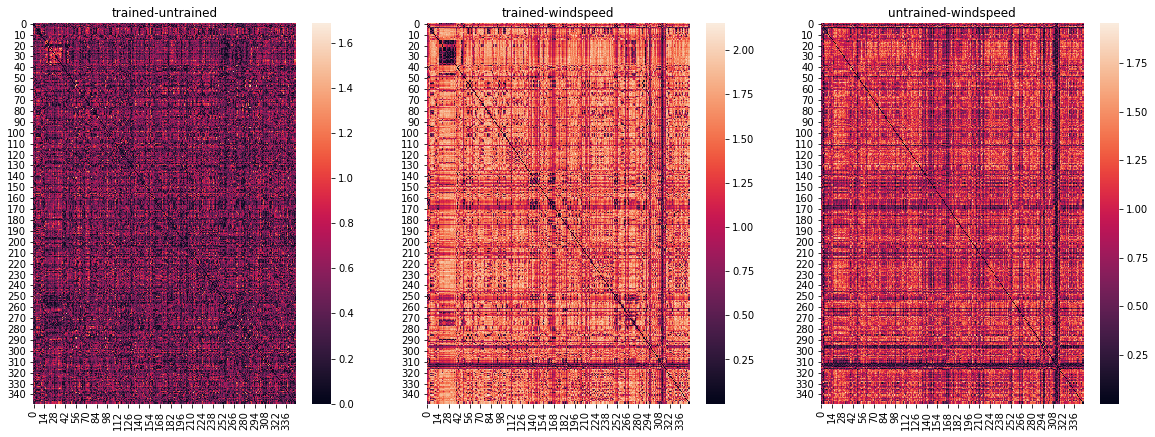

In [21]:
plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
plt.title('trained-untrained')
sns.heatmap(abs(sim.detach().numpy()-untrained_sim.detach().numpy()))

plt.subplot(1,3,2)
plt.title('trained-windspeed')
sns.heatmap(abs(sim.detach().numpy()-windspeed_diff))

plt.subplot(1,3,3)
plt.title('untrained-windspeed')
sns.heatmap(abs(untrained_sim.detach().numpy()-windspeed_diff))
plt.show()

---

# Content

* [latent_vector의 Similarity로 KNN하여 풍속 예측](#Experiment_1)
* [latent_vector의 Similarity로 KNN하여 풍속 예측+CART로 다시한것](#Experiment_2)
* [KNN, Similarity Distance](#Experiment_3)


* [Report 1](#Report_1) *66번 인덱스*
* [Report 2](#Report_2) *104번 인덱스*
* [Report 3](#Report_3) *345번 인덱스*
* [Report 4](#Report_4) *4번 인덱스*
* [Report 5](#Report_5) *309번 인덱스*
* [Report 6](#Report_6) *39번 인덱스*

---

# Experiment_3
* KNN, apply Similarity Weight

[go to content](#Content)

In [22]:
with open('../../Share_Data/windspeed/Baseline_KNN_group.pickle', 'rb') as f:
    KNN_group = pickle.load(f)

with open('../../Share_Data/windspeed/Baseline_KNN_error.pickle', 'rb') as f:
    KNN_error = pickle.load(f)
    
with open('../../Share_Data/windspeed/Baseline_KNN_abs_error.pickle', 'rb') as f:
    KNN_abs_error = pickle.load(f)
    
cov_np = sim.detach().numpy()

In [25]:
# K = 15, Similarity 반영

similarity_list =[]
exp3_result = []

for index, station_code in enumerate(list(windspeed_dataset)):
    NN_group = list(KNN_group[station_code])
    NN_index = list(map(lambda x:list(windspeed_dataset).index(x), NN_group))
    similarity_list.append(cov_np[index][NN_index])
    NN_windspeed = windspeed_list[NN_index]
    exp3_result.append(sum(NN_windspeed*1/(cov_np[index][NN_index]))/sum(1/(cov_np[index][NN_index])))

mean : 3.901399465788886
std : 4.325841072095999


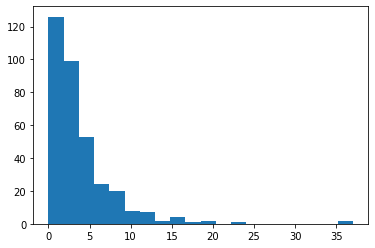

In [26]:
_result = exp3_result-windspeed_list
#plt.hist(_result, bins=20)
#print('mean : {}'.format(np.mean(_result)))
#print('std : {}'.format(np.std(_result)))
#plt.show()

_result = np.abs(_result)
plt.hist(_result, bins=20)
print('mean : {}'.format(np.mean(_result)))
print('std : {}'.format(np.std(_result)))
plt.show()


In [27]:
# Except 10
N = 10
_test = _result
for _ in range(N):
    _test = np.delete(_test, np.where(_test==max(_test))[0])
print(np.mean(_test))

# Except 20
N = 20
_test = _result
for _ in range(N):
    _test = np.delete(_test, np.where(_test==max(_test))[0])
print(np.mean(_test))

3.3868597969420557
3.116846134888259


### Sub Analysis 
* place distance vs similarity distance

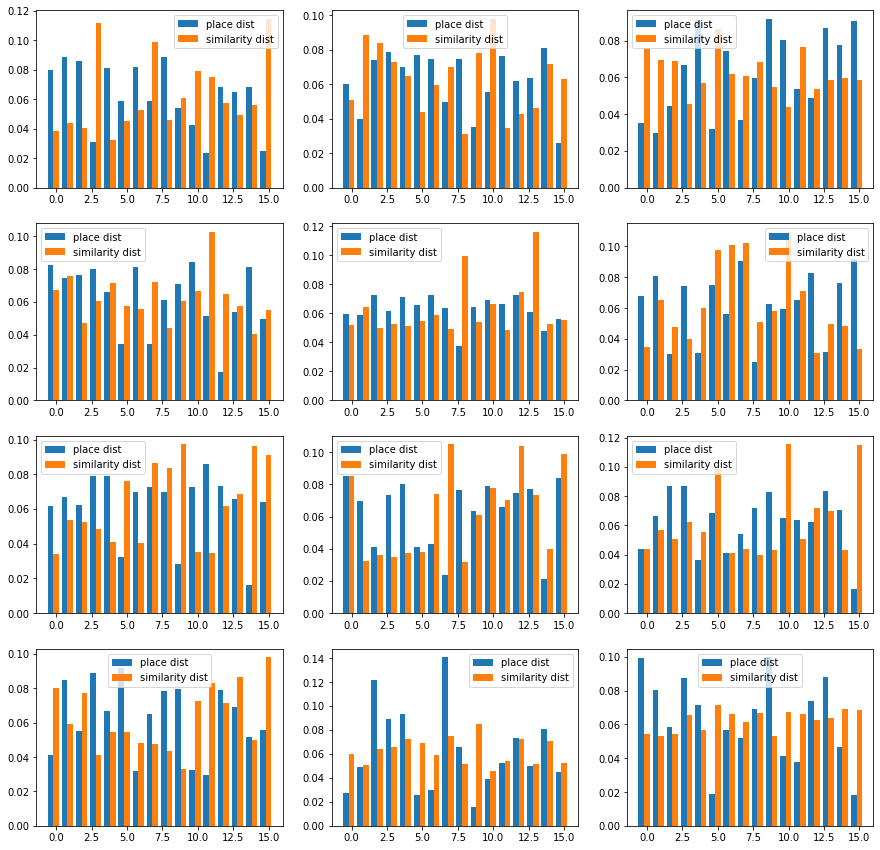

In [88]:
select_Num = 12
print_col = 3
print_row = 4

random_select = np.random.permutation(np.arange(len(windspeed_list)))[:select_Num]

plt.figure(figsize=(15,15))
for i, index in enumerate(random_select):
    staion_code = np.array(list(KNN_group))[index]
    plt.subplot(print_row, print_col, i+1)
    plt.bar(np.arange(len(KNN_group[staion_code]))-0.4, np.array(list(KNN_group[staion_code].values()))/sum(list(KNN_group[staion_code].values())), width=0.4, label='place dist')
    plt.bar(np.arange(len(KNN_group[staion_code])), similarity_list[index]/sum(similarity_list[index]), width=0.4,label='similarity dist')
    plt.legend()
plt.show()

In [69]:
print('KNN에 비해 개선 된 결과 수 : {}, 나빠진 곳 : {}, 총 : {}'.format(sum(KNN_error > _result), sum(KNN_error < _result), len(KNN_error)))

KNN에 비해 개선 된 결과 수 : 176, 나빠진 곳 : 173, 총 : 349


* 오... 생각보다 많이 개선 되네?

### 단순히 2개의 평균을 해보자

In [1]:
# origin - KNN
# 추후 연구할만한 것이 될듯.
mean_result = (0.8*(KNN_abs_error)+0.2*(exp3_result-windspeed_list))/1

NameError: name 'KNN_abs_error' is not defined

In [2]:
#plt.hist(mean_result, bins=20)
#print('mean : {}'.format(np.mean(mean_result)))
#print('std : {}'.format(np.std(mean_result)))
#plt.show()

_result = np.abs(mean_result)
plt.hist(_result, bins=20)
print('mean : {}'.format(np.mean(_result)))
print('std : {}'.format(np.std(_result)))
plt.show()

NameError: name 'np' is not defined

In [32]:
# Except 10
N = 10
_test = _result
for _ in range(N):
    _test = np.delete(_test, np.where(_test==max(_test))[0])
print(np.mean(_test))

# Except 20
N = 20
_test = _result
for _ in range(N):
    _test = np.delete(_test, np.where(_test==max(_test))[0])
print(np.mean(_test))

3.014742708600243
2.8281135855891506


In [33]:
Y = list(map(lambda x : np.mean(np.abs(x*(KNN_abs_error)+(1-x)*(exp3_result-windspeed_list)/1)), np.arange(0,1,0.01)))

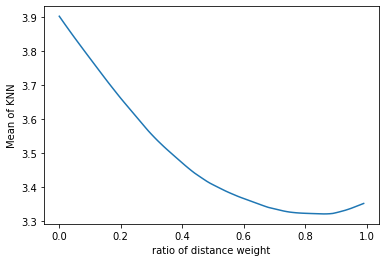

In [34]:
plt.plot(np.arange(0,1,0.01), Y)
plt.ylabel('Mean of KNN')
plt.xlabel('ratio of distance weight')
plt.show()

In [35]:
min(Y)

3.3216383291140823

In [36]:
np.where(Y==min(Y))

(array([86]),)

In [37]:
# origin - KNN
mean_result = (0.86*(KNN_abs_error)+0.14*(exp3_result-windspeed_list))/1

mean : 3.3216383291140823
std : 2.7988588921636195


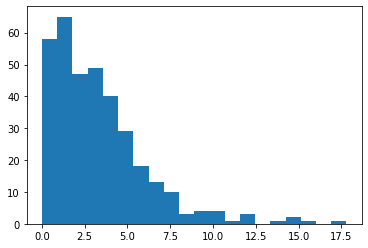

In [38]:
#plt.hist(mean_result, bins=20)
#print('mean : {}'.format(np.mean(mean_result)))
#print('std : {}'.format(np.std(mean_result)))
#plt.show()

_result = np.abs(mean_result)
plt.hist(_result, bins=20)
print('mean : {}'.format(np.mean(_result)))
print('std : {}'.format(np.std(_result)))
plt.show()

In [39]:
# Except 10
N = 10
_test = _result
for _ in range(N):
    _test = np.delete(_test, np.where(_test==max(_test))[0])
print(np.mean(_test))

# Except 20
N = 20
_test = _result
for _ in range(N):
    _test = np.delete(_test, np.where(_test==max(_test))[0])
print(np.mean(_test))

3.023389909924649
2.8370701621355656


# Experiment_2
* 한번 latent_vector의 similarty를 기준으로 구해볼까...?
* windspeed의 기록을 CART가 분류한 값을 이용해서

[go to content](#Content)

In [40]:
import geopy.distance as gedistc

In [41]:
with open('../../Share_Data/windspeed/New_Windspeed.pickle', 'rb') as f:
    new_windspeed = pickle.load(f)

In [42]:
with open('../../Share_Data/windspeed/cart_change_windspeed.pickle', 'rb') as f:
    cart_windspeed = pickle.load(f)

In [43]:
num_K = 15
cov_np = sim.detach().numpy()
similar_list = []
result = []

wind_select_f = lambda x : list(new_windspeed.values())[x]
code_select_f = lambda x : list(windspeed_dataset)[x]

# 가중치 없이 그냥 평균
for i_index in range(len(station_list)):
    select_list = cov_np[i_index].argsort()[-1-num_K : -1]
    select_wind = list(map(wind_select_f, select_list))
    select_code = list(map(code_select_f, select_list))
    select_dic = dict(zip(select_code, select_wind))
    similar_list.append(select_dic)
    
    result.append(np.mean(select_wind))

In [44]:
# distance weight sum

weight_result = []

for i_index, (to_code, to_dic) in enumerate(windspeed_dataset.items()):
    to_place = to_dic[:2]
    distance_list = []
    for j_index in similar_list[i_index]:
        from_place = windspeed_dataset[j_index][:2]
        distance_list.append(1/gedistc.distance(to_place, from_place).km) 
    weight_windspeed = sum(np.array(list(similar_list[i_index].values())) * np.array(distance_list))
    weight_result.append(weight_windspeed/sum(distance_list))

3.7617274240829115
3.952677493372429


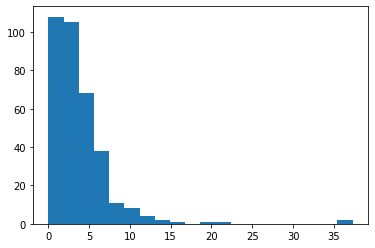

In [45]:
# --- k = 15
# --- Not distance Weight

#plt.hist(windspeed_list-result, bins=20)
#print(np.mean(windspeed_list-result))
#print(np.std(windspeed_list-result))
#plt.show()
data = np.abs(windspeed_list-result)

plt.hist(data, bins=20)
print(np.mean(data))
print(np.std(data))
plt.show()

In [46]:
# Except 10
N = 10
_test = data
for _ in range(N):
    _test = np.delete(_test, np.where(_test==max(_test))[0])
print(np.mean(_test))

# Except 20
N = 20
_test = data
for _ in range(N):
    _test = np.delete(_test, np.where(_test==max(_test))[0])
print(np.mean(_test))

3.29939135062901
3.08845862602683


3.8185688970462364
3.9534950115720826


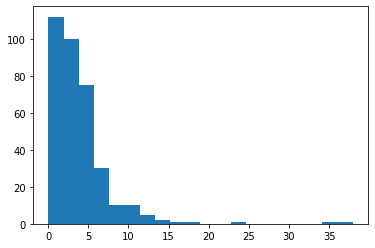

In [47]:
# --- k = 15
# --- apply distance Weight

#plt.hist(windspeed_list-weight_result, bins=20)
#print(np.mean(windspeed_list-weight_result))
#print(np.std(windspeed_list-weight_result))
#plt.show()

plt.hist(np.abs(windspeed_list-weight_result), bins=20)
print(np.mean(np.abs(windspeed_list-weight_result)))
print(np.std(np.abs(windspeed_list-weight_result)))
plt.show()

## Conclusion

* 이게더 좋긴함

---
# Experiment_1
* 한번 latent_vector의 similarty를 기준으로 구해볼까...?

[go to content](#Content)

In [48]:
import geopy.distance as gedistc

In [49]:
num_K = 15
cov_np = sim.detach().numpy()
similar_list = []
result = []

wind_select_f = lambda x : windspeed_list[x]
code_select_f = lambda x : list(windspeed_dataset)[x]

# 가중치 없이 그냥 평균
for i_index in range(len(station_list)):
    select_list = cov_np[i_index].argsort()[-1-num_K : -1]
    select_wind = list(map(wind_select_f, select_list))
    select_code = list(map(code_select_f, select_list))
    select_dic = dict(zip(select_code, select_wind))
    similar_list.append(select_dic)
    
    result.append(np.mean(select_wind))

In [50]:
# distance weight sum

weight_result = []

for i_index, (to_code, to_dic) in enumerate(windspeed_dataset.items()):
    to_place = to_dic[:2]
    distance_list = []
    for j_index in similar_list[i_index]:
        from_place = windspeed_dataset[j_index][:2]
        distance_list.append(1/gedistc.distance(to_place, from_place).km) 
    weight_windspeed = sum(np.array(list(similar_list[i_index].values())) * np.array(distance_list))
    weight_result.append(weight_windspeed/sum(distance_list))

3.669239635403129
3.9419335161401787


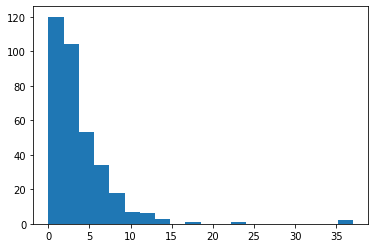

In [51]:
# --- k = 15
# --- Not distance Weight

#plt.hist(windspeed_list-result, bins=20)
#print(np.mean(windspeed_list-result))
#print(np.std(windspeed_list-result))
#plt.show()

data = np.abs(windspeed_list-result)

plt.hist(data, bins=20)
print(np.mean(data))
print(np.std(data))
plt.show()

In [52]:
# Except 10
N = 10
_test = data
for _ in range(N):
    _test = np.delete(_test, np.where(_test==max(_test))[0])
print(np.mean(_test))

# Except 20
N = 20
_test = data
for _ in range(N):
    _test = np.delete(_test, np.where(_test==max(_test))[0])
print(np.mean(_test))

3.2149059101031345
2.9960678936371066


3.7396802273153753
3.9490802242966656


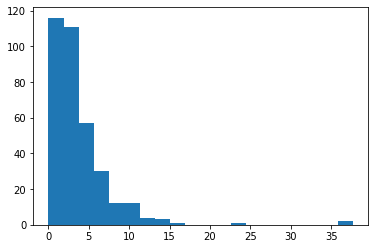

In [53]:
# --- k = 15
# --- apply distance Weight

#plt.hist(windspeed_list-weight_result, bins=20)
#print(np.mean(windspeed_list-weight_result))
#print(np.std(windspeed_list-weight_result))
#plt.show()

data = np.abs(windspeed_list-weight_result)

plt.hist(data, bins=20)
print(np.mean(data))
print(np.std(data))
plt.show()

In [54]:
# Except 10
N = 10
_test = data
for _ in range(N):
    _test = np.delete(_test, np.where(_test==max(_test))[0])
print(np.mean(_test))

# Except 20
N = 20
_test = data
for _ in range(N):
    _test = np.delete(_test, np.where(_test==max(_test))[0])
print(np.mean(_test))

3.287154684659218
3.0616045820256588


## 이전 Baseline에서 확인된 오차가 개선됬는지 체크하자

---
# Report_3
* 294(인덱스 347)
* 162(309)
* 909(251)
* 918(259)
* 921(262)

[go to content](#Content)

In [28]:
a_index = 347
b_index = 309
c_index = 251
d_index = 259
e_index = 262

In [29]:
# z list
select_value = []
select_value.append(model_projection[a_index].detach().numpy())
select_value.append(model_projection[b_index].detach().numpy())
select_value.append(model_projection[c_index].detach().numpy())
select_value.append(model_projection[d_index].detach().numpy())
select_value.append(model_projection[e_index].detach().numpy())

# origin
img_a = (img_list[a_index]+1)/2
img_b = (img_list[b_index]+1)/2
img_c = (img_list[c_index]+1)/2
img_d = (img_list[d_index]+1)/2
img_e = (img_list[e_index]+1)/2

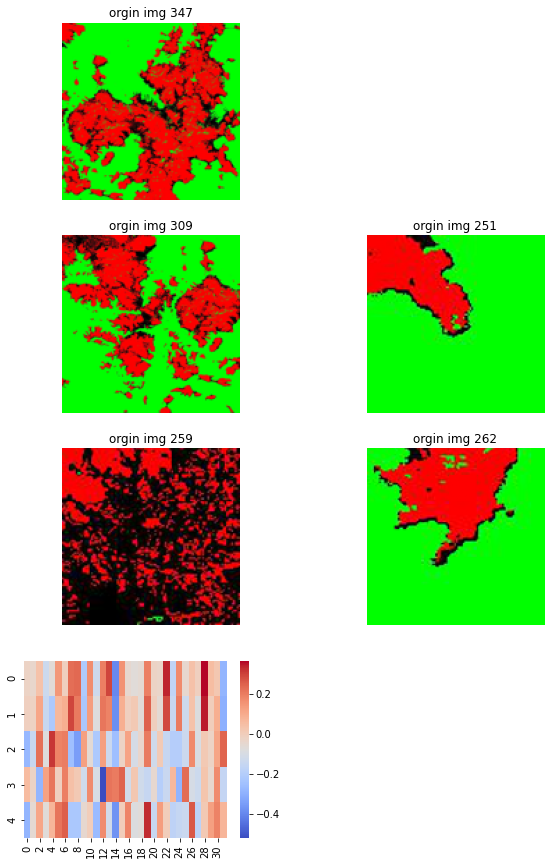

In [30]:
plt.figure(figsize=(10,15))

plt.subplot(4,2,1)
plt.imshow(img_a)
plt.title('orgin img {}'.format(a_index))
plt.axis('off')

plt.subplot(4,2,3)
plt.imshow(img_b)
plt.title('orgin img {}'.format(b_index))
plt.axis('off')

plt.subplot(4,2,4)
plt.imshow(img_c)
plt.title('orgin img {}'.format(c_index))
plt.axis('off')

plt.subplot(4,2,5)
plt.imshow(img_d)
plt.title('orgin img {}'.format(d_index))
plt.axis('off')

plt.subplot(4,2,6)
plt.imshow(img_e)
plt.title('orgin img {}'.format(e_index))
plt.axis('off')

plt.subplot(4,2,7)
sns.heatmap(select_value, cmap='coolwarm')
plt.show()

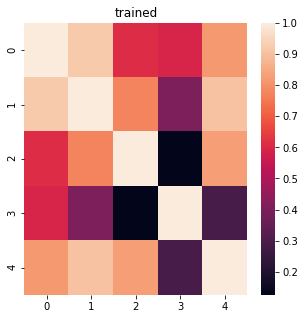

In [17]:
v_tensor = torch.tensor(select_value)

z_n = v_tensor.norm(dim=1)[:,None]
z_n = torch.max(z_n, 1e-8*torch.ones_like(z_n))

cov = torch.mm(v_tensor/z_n, (v_tensor/z_n).t().contiguous())

plt.figure(figsize=(5,5))
plt.title('trained')
sns.heatmap(cov.detach().numpy())

plt.show()

In [19]:
(cov.detach().numpy()[a_index]).argsort()[-2]

309

In [20]:
cov.detach().numpy()[a_index, 309]

0.92294574

In [21]:
list(windspeed_dataset)[309]

'162'

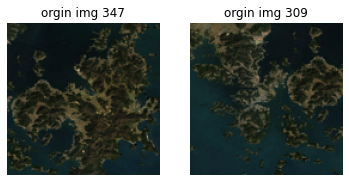

In [23]:
img_similar = (img_list[309]+1)/2

plt.subplot(1,2,1)
plt.imshow(img_a)
plt.title('orgin img {}'.format(a_index))
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_similar)
plt.title('orgin img {}'.format('309'))
plt.axis('off')

plt.show()

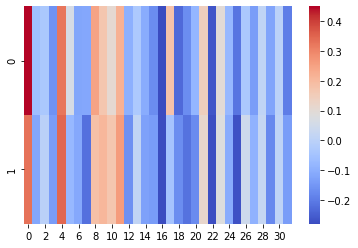

In [25]:
a_z = model_projection[347].detach().numpy().reshape(1,-1)
b_z = model_projection[309].detach().numpy().reshape(1,-1)
total_z = np.concatenate([a_z, b_z], axis=0)

sns.heatmap(total_z, cmap='coolwarm')
plt.show()

* 오... 일단 similar는 VAE에 비해 상다잏 좋은데?

### Report_1
* 66번 인덱스와 39번 인덱스 차이 비교

[go to content](#Content)

In [23]:
select_value = []
select_value.append(model_projection[66].detach().numpy())
select_value.append(model_projection[39].detach().numpy())

<AxesSubplot:>

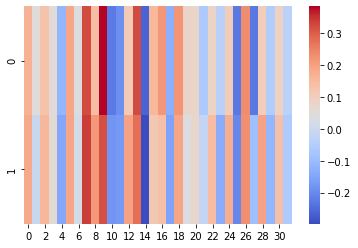

In [26]:
sns.heatmap(select_value, cmap='coolwarm')